In [1]:
!pip install selenium pandas webdriver-manager

  Using cached selenium-4.35.0-py3-none-any.whl.metadata (7.4 kB)
  Using cached trio-0.30.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached trio_websocket-0.12.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached outcome-1.3.0.post0-py2.py3-none-any.whl.metadata (2.6 kB)
  Using cached wsproto-1.2.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached PySocks-1.7.1-py3-none-any.whl.metadata (13 kB)
Using cached selenium-4.35.0-py3-none-any.whl (9.6 MB)
Using cached trio-0.30.0-py3-none-any.whl (499 kB)
Using cached trio_websocket-0.12.2-py3-none-any.whl (21 kB)
Using cached PySocks-1.7.1-py3-none-any.whl (16 kB)
Using cached outcome-1.3.0.post0-py2.py3-none-any.whl (10 kB)
Using cached wsproto-1.2.0-py3-none-any.whl (24 kB)
Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl (29 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [selenium]8/9 [selenium]


In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time

# ----------------------------
# 1️⃣ Chrome setup
# ----------------------------
options = Options()
options.add_argument("--start-maximized")
# options.add_argument("--headless")  # Uncomment if you want headless
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# ----------------------------
# 2️⃣ Open forum page
# ----------------------------
url = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans"
driver.get(url)

# ----------------------------
# 3️⃣ Close privacy popup if it appears
# ----------------------------
try:
    close_btn = WebDriverWait(driver, 5).until(
        EC.element_to_be_clickable((By.CSS_SELECTOR, "button.close-btn"))
    )
    driver.execute_script("arguments[0].click();", close_btn)
    time.sleep(1)
except TimeoutException:
    pass

# ----------------------------
# 4️⃣ Detect last page number (for info)
# ----------------------------
try:
    pager_links = driver.find_elements(By.CSS_SELECTOR, "a.Pager-p")
    last_page = max([int(link.text) for link in pager_links if link.text.isdigit()])
except:
    last_page = 1

print(f"🔢 Last page detected (for info): {last_page}")

# ----------------------------
# 5️⃣ Initialize lists and counters
# ----------------------------
all_usernames, all_messages, all_dates = [], [], []
page_count = 0
cumulative_posts = 0

# ----------------------------
# 6️⃣ Loop through pages (stop at 200)
# ----------------------------
while page_count < 200:
    page_count += 1

    # Wait for posts to load
    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, "div.Message.userContent"))
    )
    time.sleep(2)

    # ---- Extract usernames ----
    hrefs = driver.find_elements(By.TAG_NAME, "a")
    substring = "profile"
    usernames = []
    for lnk in hrefs:
        full_link = lnk.get_attribute('href')
        class_attr = lnk.get_attribute('class') or ""
        if full_link and substring in full_link and "Username" in class_attr:
            usernames.append(full_link.split("/profile/")[1])

    # Extract messages
    posts = driver.find_elements(By.CSS_SELECTOR, "div.Message.userContent")
    messages = []
    for post in posts:
        for bq in post.find_elements(By.TAG_NAME, "blockquote"):
            driver.execute_script("arguments[0].remove();", bq)
        messages.append(post.text.strip())

    # Extract dates
    time_elements = driver.find_elements(By.CSS_SELECTOR, "a.Permalink > time")
    dates = [t.get_attribute("title") for t in time_elements]

    #Append to master lists
    num_posts = len(messages)
    cumulative_posts += num_posts
    for i in range(num_posts):
        all_usernames.append(usernames[i] if i < len(usernames) else None)
        all_dates.append(dates[i] if i < len(dates) else None)
        all_messages.append(messages[i])

    # 🟢 Log progress
    print(f"Processing page {page_count} ... {num_posts} posts scraped | Cumulative posts: {cumulative_posts}")

    # ---- Stop if no next page ----
    try:
        next_btn = driver.find_element(By.CSS_SELECTOR, "a.Next")
        driver.execute_script("arguments[0].click();", next_btn)
        time.sleep(3)
    except:
        break

# ----------------------------
# 7️⃣ Quit driver
# ----------------------------
driver.quit()

# ----------------------------
# 8️⃣ Save to CSV
# ----------------------------
df = pd.DataFrame({
    "userid": all_usernames,
    "date": all_dates,
    "message": all_messages
})

df.to_csv("edmunds_forum_first_200_pages.csv", index=False)
print(f"✅ Saved {len(df)} posts to edmunds_forum_first_200_pages.csv")

# ----------------------------
# 9️⃣ Summary
# ----------------------------
print(f"Total pages scraped: {page_count}")
print(f"Total posts scraped: {len(df)}")
print(df.head(20))


🔢 Last page detected (for info): 435
Processing page 1 ... 51 posts scraped | Cumulative posts: 51
Processing page 2 ... 50 posts scraped | Cumulative posts: 101
Processing page 3 ... 50 posts scraped | Cumulative posts: 151
Processing page 4 ... 50 posts scraped | Cumulative posts: 201
Processing page 5 ... 50 posts scraped | Cumulative posts: 251
Processing page 6 ... 50 posts scraped | Cumulative posts: 301
Processing page 7 ... 50 posts scraped | Cumulative posts: 351
Processing page 8 ... 50 posts scraped | Cumulative posts: 401
Processing page 9 ... 50 posts scraped | Cumulative posts: 451
Processing page 10 ... 50 posts scraped | Cumulative posts: 501
Processing page 11 ... 50 posts scraped | Cumulative posts: 551
Processing page 12 ... 50 posts scraped | Cumulative posts: 601
Processing page 13 ... 50 posts scraped | Cumulative posts: 651
Processing page 14 ... 50 posts scraped | Cumulative posts: 701
Processing page 15 ... 50 posts scraped | Cumulative posts: 751
Processing pa

## Task A: Testing Zipf's Law in Edmunds Forum Data

          userid                    date  \
0       cybersol  March 23, 2002 12:04PM   
1          merc1  March 24, 2002 10:54PM   
2         fredvh  March 25, 2002 12:06AM   
3  blueguydotcom  March 25, 2002 10:02AM   
4    hungrywhale   March 25, 2002 4:04PM   

                                             message  
0  Entry level performance luxury sedans are a ho...  
1  I personally think that with a few tweaks the ...  
2  I am debating a new purchase and these two are...  
3  Great handling, RWD, excellent engine and the ...  
4  And no manual tranny. That may not matter to y...  
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 1.082e+06
Date:                Thu, 11 Sep 2025   Prob (F-statistic):               0.00
Time:     

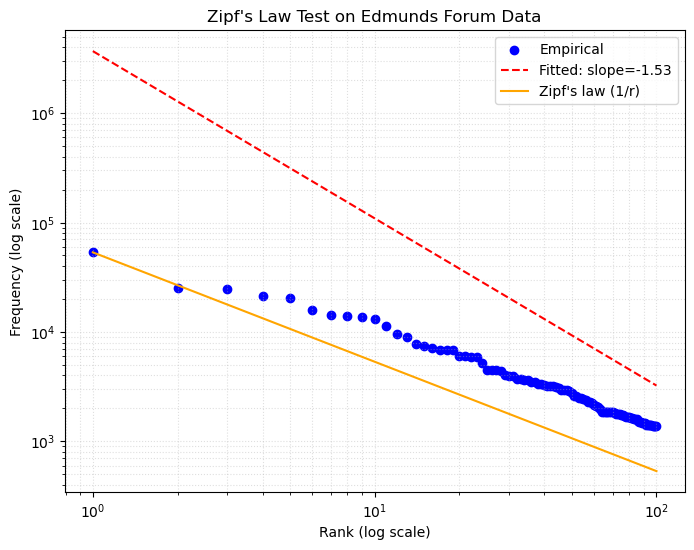

In [8]:
# ==============================
# Task A: Testing Zipf's Law in Edmunds Forum Data
# ==============================

# Step 1: Load CSV directly (Jupyter)
import pandas as pd

# Adjust extension if needed (e.g., .csv/.txt)
csv_path = "edmunds_forum_first_200_pages.csv"
df = pd.read_csv(csv_path)

# Preview dataset (make sure it has 'message' column)
print(df.head())

# ==============================
# Step 2: Tokenize & compute frequencies
# ==============================
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def tokenize(text):
    """Lowercase, extract alphanumeric words. No stopword removal."""
    if not isinstance(text, str):
        return []
    return re.findall(r"\b[a-zA-Z0-9]+\b", text.lower())

# Tokenize all messages
all_tokens = []
for msg in df["message"]:
    all_tokens.extend(tokenize(msg))

# Word frequency
word_counts = Counter(all_tokens)
freq_df = pd.DataFrame(word_counts.items(), columns=["word", "freq"])
freq_df = freq_df.sort_values("freq", ascending=False).reset_index(drop=True)
freq_df["rank"] = freq_df.index + 1

# ==============================
# Step 3: Regression log(freq) ~ log(rank)
# ==============================
import statsmodels.api as sm

freqs = freq_df["freq"].values
ranks = freq_df["rank"].values
logf = np.log(freqs)
logr = np.log(ranks)

X = sm.add_constant(logr)  # add intercept
model = sm.OLS(logf, X).fit()
print(model.summary())

# Regression results
a, b = model.params  # intercept, slope
print(f"Intercept (a): {a:.4f}, Slope (b): {b:.4f}, R²: {model.rsquared:.4f}")

# ==============================
# Step 4: Plot top 100 words vs Zipf's law
# ==============================
top_n = 100
df_top = freq_df.head(top_n)

plt.figure(figsize=(8,6))
plt.scatter(df_top["rank"], df_top["freq"], label="Empirical", color="blue")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Rank (log scale)")
plt.ylabel("Frequency (log scale)")
plt.title("Zipf's Law Test on Edmunds Forum Data")

# Fitted line
fitted = np.exp(a) * (df_top["rank"] ** b)
plt.plot(df_top["rank"], fitted, 'r--', label=f"Fitted: slope={b:.2f}")

# Theoretical Zipf (s=1), scaled to freq of rank 1
C = df_top["freq"].iloc[0]
theo = C * (df_top["rank"] ** -1.0)
plt.plot(df_top["rank"], theo, 'orange', label="Zipf's law (1/r)")

plt.legend()
plt.grid(True, which="both", ls=":", alpha=0.4)
plt.show()


## TASK B: Create the top 10 (model, brand) pairs

In [12]:
#To Read the brand CSV and create a list of (model, brand) pairs.

def load_brand_map(brands_file_path):
    
    df_brands = pd.read_csv(brands_file_path)

    # Make all values lowercase
    df_brands = df_brands.applymap(lambda x: str(x).lower())

    # List of words to exclude since they are not models
    exclude_words = ["car", "cars", "problem", "problems", "seat", "seats", "sedan", "sedans"]

    # Filter out rows where 'Model' is in the exclusion list
    df_brands = df_brands[~df_brands["Model"].isin(exclude_words)]
    
    # Build dictionary {model: brand}
    model_to_brand = dict(zip(df_brands["Model"], df_brands["Brand"]))
    
    # Add brand names themselves to the dictionary
    brand_dict = dict(zip(df_brands["Brand"], df_brands["Brand"]))

    # Merge both
    model_to_brand.update(brand_dict)

    # print(model_to_brand)
    
    brand_clean_map = {
        "mercedes-benz": "mercedes",
        "mercedes benz": "mercedes",
        "volkwagen": "volkswagen",   # typo fix
        # add more if needed
    }

    # Apply cleaning map to dictionary values
    model_to_brand = {model: brand_clean_map.get(brand, brand) 
                      for model, brand in model_to_brand.items()}
    
    # We sort the map by the length of the model name.
    # This makes sure we match longer names first (e.g., "c-class" before "c").
    # This prevents incorrect matches.
    sorted_map = sorted(model_to_brand.items(), key=lambda item: len(item[0]), reverse=True)
    # print(sorted_map)
    return sorted_map

brands_file = 'car_models_and_brands.csv'
model_brand_mapping = load_brand_map(brands_file)

/var/folders/b8/ly6z8_414y9ftxvndlryh6mc0000gn/T/ipykernel_61560/1068050206.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_brands = df_brands.applymap(lambda x: str(x).lower())


In [27]:
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
english_stopwords = set(stopwords.words('english'))

def count_brand_mentions(forum_file_path, model_brand_list):
    
    df_forum = pd.read_csv(forum_file_path)
    
    #Drop empty messages
    messages = df_forum['message'].dropna()

    # Use a Counter object to store our brand counts
    brand_counts = Counter()

    for message in messages:
        # Make the message lowercase to make matching easier.
        text = message.lower()
        
        # This set will store the unique brands found in this message.
        # This is how we make sure to count "BMW" only once, even if a user mentions it five times in their post.
        found_brands_in_message = set()

        # Check for each model in our brand list.
        for model, brand in model_brand_list:
            # We use a simple search to see if the model name is in the text.
            # The `\b` part is a regex trick to match whole words only.
            if re.search(r'\b' + re.escape(model) + r'\b', text):
                found_brands_in_message.add(brand)

        found_brands_in_message -= english_stopwords
        
        brand_counts.update(found_brands_in_message)

    return brand_counts

forum_file = 'edmunds_forum_first_200_pages.csv'
final_counts = count_brand_mentions(forum_file, model_brand_mapping)

[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
print("\nTop 10 Most Mentioned Car Brands:\n")
print(f"{'Rank':<5} | {'Brand':<15} | {'Mention Count'}")
print("-" * 40)

top_10 = final_counts.most_common(10)
for i, (brand, count) in enumerate(top_10, 1):
    print(f"{i:<5} | {brand:<15} | {count}")



Top 10 Most Mentioned Car Brands:

Rank  | Brand           | Mention Count
----------------------------------------
1     | bmw             | 3288
2     | acura           | 993
3     | audi            | 986
4     | honda           | 814
5     | infiniti        | 733
6     | toyota          | 679
7     | mercedes        | 470
8     | nissan          | 457
9     | cadillac        | 356
10    | volkswagen      | 354


## TASK C - Calculate lift ratios for associations between the top-10 brands identified in Task A.

In [29]:
# ============================
# TASK C — Lift Ratios (Top-10)
# ============================

# 1) Get top-10 brands from Task A counts
top10_car_brands = pd.DataFrame(final_counts.most_common(10), columns=["brand", "count"])

# 2) Build tokenized unique brand mentions per message (set per post)
df_forum = pd.read_csv(forum_file)
messages = df_forum['message'].dropna()

message_tokens_unique = []
for msg in messages:
    text = str(msg).lower()
    found = set()
    for model, brand in model_brand_mapping:
        if re.search(r'\b' + re.escape(model) + r'\b', text):
            found.add(brand)
    # count each brand at most once per message
    message_tokens_unique.append(found)

# 3) Function to compute lift
def lift_analysis(a, b, message_tokens):
    freq_a, freq_b, freq_a_b = 0, 0, 0
    n = len(message_tokens)
    if a == b:
        return 0
    for brands in message_tokens:
        if a in brands:
            freq_a += 1
        if b in brands:
            freq_b += 1
        if a in brands and b in brands:
            freq_a_b += 1
    if freq_a == 0:
        return (float(n) * freq_a_b) / (freq_b or 1)
    elif freq_b == 0:
        return (float(n) * freq_a_b) / (freq_a or 1)
    else:
        return (float(n) * freq_a_b) / (freq_a * freq_b)

# 4) Build lift matrix for top-10 brands
lift_df = []
for _, a in top10_car_brands.iterrows():
    for _, b in top10_car_brands.iterrows():
        lift_df.append(lift_analysis(a["brand"], b["brand"], message_tokens_unique))

import numpy as np
lift_matrix = np.reshape(lift_df, (10, 10))
lift_data = pd.DataFrame(data=lift_matrix)

# Rename rows/cols with brand names
for i in range(10):
    lift_data = lift_data.rename(columns={i: top10_car_brands.iloc[i, 0]})
    lift_data = lift_data.rename(index={i: top10_car_brands.iloc[i, 0]})

print("\nLift Ratio Matrix (Top-10):")
#print(lift_data.round(3))
lift_data


Lift Ratio Matrix (Top-10):


,bmw,acura,audi,honda,infiniti,toyota,mercedes,nissan,cadillac,volkswagen
bmw,0.000000,1.439406,1.649679,1.245185,1.825771,1.452531,1.898284,1.128871,1.943554,1.457328
acura,1.439406,0.000000,2.354124,2.962655,3.646464,1.894238,2.480015,2.440625,2.907244,2.157270
audi,1.649679,2.354124,0.000000,1.504276,2.581691,1.386053,3.617246,1.306479,3.297422,4.488105
honda,1.245185,2.962655,1.504276,0.000000,1.321120,4.061924,1.903900,3.835650,1.515032,2.666285
infiniti,1.825771,3.646464,2.581691,1.321120,0.000000,1.543691,2.867325,3.008463,3.594325,2.268759
toyota,1.452531,1.894238,1.386053,4.061924,1.543691,0.000000,2.032307,3.794369,1.609861,1.992561
mercedes,1.898284,2.480015,3.617246,1.903900,2.867325,2.032307,0.000000,1.533004,4.412933,3.538298
nissan,1.128871,2.440625,1.306479,3.835650,3.008463,3.794369,1.533004,0.000000,1.471935,3.083856
cadillac,1.943554,2.907244,3.297422,1.515032,3.594325,1.609861,4.412933,1.471935,0.000000,1.979385
volkswagen,1.457328,2.157270,4.488105,2.666285,2.268759,1.992561,3.538298,3.083856,1.979385,0.000000


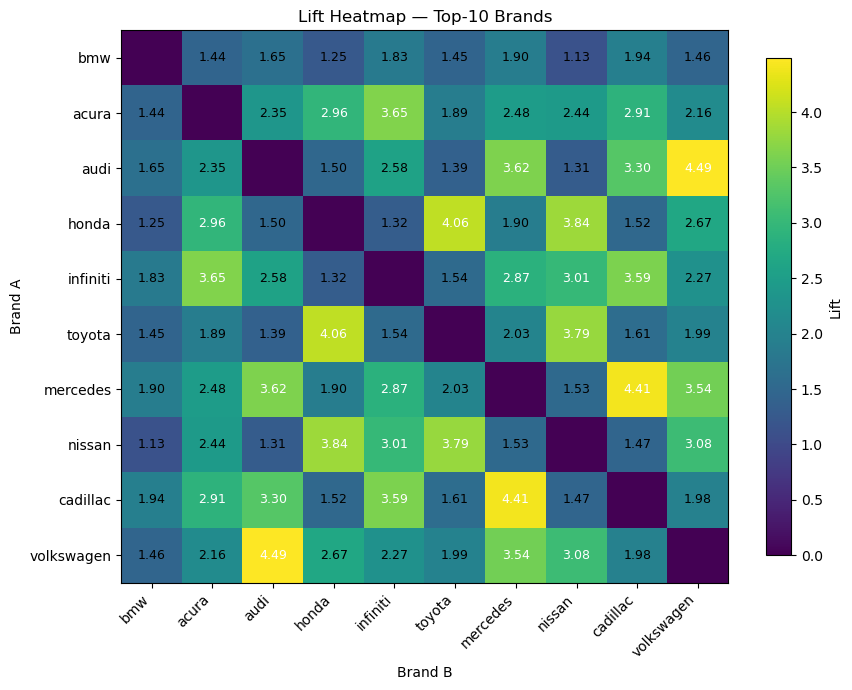

Saved heatmap -> lift_heatmap_top10.png


In [30]:
# ==========================
# Lift Heatmap (Task C)
# ==========================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize  # optional, for text color logic

# Use the lift_data DataFrame created above (10x10, indexed by brand)
brands = list(lift_data.index)
lift_mat = lift_data.loc[brands, brands].copy()

# Clean for plotting
plot_mat = lift_mat.replace([np.inf, -np.inf], np.nan).fillna(0).values

# Plot
fig, ax = plt.subplots(figsize=(9, 7))
im = ax.imshow(plot_mat, cmap='viridis', aspect='auto')

ax.set_xticks(range(len(brands)))
ax.set_yticks(range(len(brands)))
ax.set_xticklabels(brands, rotation=45, ha='right')
ax.set_yticklabels(brands)

ax.set_title("Lift Heatmap — Top-10 Brands")
ax.set_xlabel("Brand B")
ax.set_ylabel("Brand A")

cbar = plt.colorbar(im, ax=ax, shrink=0.9)
cbar.set_label("Lift", rotation=90)

# Annotate (skip diagonal/NaN)
for i in range(len(brands)):
    for j in range(len(brands)):
        val = lift_mat.iloc[i, j]
        if i == j or pd.isna(val):
            continue
        norm_val = im.norm(val) if isinstance(im.norm, Normalize) else 0.0
        text_color = "white" if norm_val > 0.6 else "black"
        ax.text(j, i, f"{val:.2f}", ha='center', va='center', color=text_color, fontsize=9)

plt.tight_layout()
plt.savefig("lift_heatmap_top10.png", dpi=200)
plt.show()

print("Saved heatmap -> lift_heatmap_top10.png")


## Task D: Show the brands on a multi-dimensional scaling (MDS) map 

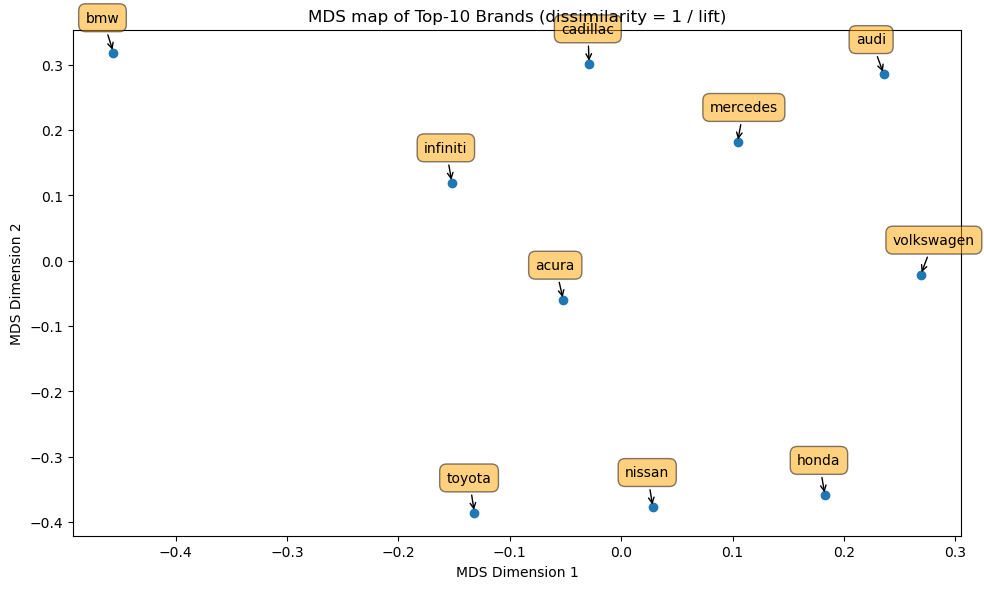

In [31]:
# ============================
# TASK D — MDS from lift_data
# ============================
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

# 1) Dissimilarity matrix from lift (handle divide-by-zero cleanly)
dissimilarity_matrix = 1 / lift_data.replace(0, np.nan)
dissimilarity_matrix = dissimilarity_matrix.replace([np.inf, -np.inf], np.nan).fillna(0)

# 2) MDS with precomputed dissimilarity
mds = manifold.MDS(
    n_components=2,
    max_iter=3000,
    eps=1e-9,
    random_state=3,
    dissimilarity="precomputed"
)
coords = mds.fit_transform(dissimilarity_matrix.values)

# 3) Plot
plt.figure(figsize=(10, 6))
plt.subplots_adjust(bottom=0.1)
plt.scatter(coords[:, 0], coords[:, 1], marker='o')

labels = lift_data.index.tolist()
for label, x, y in zip(labels, coords[:, 0], coords[:, 1]):
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(-20, 20),
        textcoords='offset points',
        ha='left',
        va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='orange', alpha=0.5),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0')
    )

plt.title("MDS map of Top-10 Brands (dissimilarity = 1 / lift)")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.tight_layout()
plt.show()


## Task E: Insights that can be offered to client – who is interested in the overall auto industry from analyses in Tasks C and D

## The Japanese mainstream - Honda, Toyota, Nissan

    Consumers frequently compare them: Honda–Toyota lift = 4.06, Honda–Nissan = 3.84, Toyota–Nissan = 3.79.

    Interpretation: Buyers see them as interchangeable choices in the affordable, reliable segment.

    Risk: Intense price and feature competition, as these brands are evaluated side by side.

## The luxury pack - Mercedes, Volkswagen, Cadillac, Audi, Infiniti, Acura

    Consumers link these brands 3–5× more often than chance (e.g., Audi–Volkswagen = 4.49, Mercedes–Cadillac = 4.41).

    Interpretation: Shoppers place these brands in the same premium consideration set.

    Risk: High substitution pressure → losing a deal to a rival luxury brand is common.

## The outlier: BMW

    BMW appears as a weak link in the market: its lift values with other brands are consistently low (~1.2–1.9).

    On the MDS map, it sits far from both the mainstream and luxury clusters, showing little overlap with competitor consideration sets.

    Interpretation: Consumers don’t cross-shop BMW much, which could limit opportunities for broader market appeal.

    Implication: While BMW is seen as unique, this distinctiveness may also restrict its audience and make it harder to capture buyers who compare multiple brands.

## Task F: Attribute Selection 

In [32]:
# loading the edmunds scrapped data into the data frame 

import pandas as pd

df = pd.read_csv("edmunds_forum_first_200_pages.csv")
print(f"Loaded {len(df)} posts from saved CSV")
print(df.head(5))

# Convert model_brand_mapping into a dictionary as need to tag the model names to the brand 

if isinstance(model_brand_mapping, list):
    if all(isinstance(x, tuple) and len(x) == 2 for x in model_brand_mapping):
        model_brand_mapping = dict((m.lower(), b.lower()) for m,b in model_brand_mapping)

    # If it's a list of dicts like [{"model":"330i","brand":"bmw"}, ...]
    elif all(isinstance(x, dict) and "model" in x and "brand" in x for x in model_brand_mapping):
        model_brand_mapping = {x["model"].lower(): x["brand"].lower() for x in model_brand_mapping}

    else:
        raise ValueError("model_brand_mapping format not recognized")



Loaded 10001 posts from saved CSV
          userid                    date  \
0       cybersol  March 23, 2002 12:04PM   
1          merc1  March 24, 2002 10:54PM   
2         fredvh  March 25, 2002 12:06AM   
3  blueguydotcom  March 25, 2002 10:02AM   
4    hungrywhale   March 25, 2002 4:04PM   

                                             message  
0  Entry level performance luxury sedans are a ho...  
1  I personally think that with a few tweaks the ...  
2  I am debating a new purchase and these two are...  
3  Great handling, RWD, excellent engine and the ...  
4  And no manual tranny. That may not matter to y...  


In [33]:
# Build Attribute Counter

import re
import numpy as np
import pandas as pd
from collections import Counter

# Ensure we have top_brands (from Task B)
top_brands = [b for b, _ in top_10]   # top_10 came from Task B
brand_set = set(top_brands)
model_set = set(model_brand_mapping.keys())

def tokenize(text):
    return re.findall(r"[a-zA-Z0-9\-]+", str(text).lower())

def is_attribute(tok):
    # Keep everything except brands/models/short tokens
    if tok in brand_set: return False
    if tok in model_set: return False
    if len(tok) <= 2: return False
    return True

# Build brand + attribute presence
messages = df['message'].fillna("").astype(str).tolist()
N = len(messages)

brand_presence = []
attr_presence = []
attr_counter = Counter()

for msg in messages:
    toks = set(tokenize(msg))
    brands = set()
    attrs = set()

    for t in toks:
        if t in brand_set:
            brands.add(t)
        elif t in model_set:
            brands.add(model_brand_mapping[t])
        elif is_attribute(t):
            attrs.add(t)

    brand_presence.append(brands)
    attr_presence.append(attrs)
    attr_counter.update(attrs)

print("Attribute counter built (all tokens except brands/models/short words).")


Attribute counter built (all tokens except brands/models/short words).


In [34]:
# Export Attribute Frequencies

all_attr_freq = pd.DataFrame(attr_counter.most_common(), columns=["attribute","count"])
all_attr_freq["pct_of_msgs"] = (all_attr_freq["count"]/N).round(4)

# Save CSV
all_attr_freq.to_csv("attribute_frequencies.csv", index=False)
print("Exported 'attribute_frequencies.csv' with all candidate attributes")

# Quick preview of top 20
display(all_attr_freq.head(20))


Exported 'attribute_frequencies.csv' with all candidate attributes


,attribute,count,pct_of_msgs
0,the,8596,0.8595
1,and,6760,0.6759
2,that,5661,0.5660
3,for,4817,0.4817
4,you,4793,0.4793
5,with,4269,0.4269
6,but,4057,0.4057
7,not,3964,0.3964
8,car,3903,0.3903
9,have,3549,0.3549


### Top 5 attributes based on manual eyeballing from "attribute_frequencies.csv" file:

### 1. luxury
### 2. interior
### 3. performance
### 4. price
### 5. engine

### Brand wise lift scores for attributes

In [35]:
# Manual Attribute Selection + Lift

# Replace these with your chosen attributes after inspecting CSV
top_attributes = ["engine", "performance", "luxury", "price", "interior"]
print("Using these attributes for Lift analysis:", top_attributes)

# Build presence matrices
brand_cols = sorted(top_brands)
attr_cols = top_attributes

brand_mat = np.zeros((N, len(brand_cols)), dtype=bool)
attr_mat  = np.zeros((N, len(attr_cols)),  dtype=bool)

for i,(bset,aset) in enumerate(zip(brand_presence, attr_presence)):
    for j,b in enumerate(brand_cols):
        if b in bset:
            brand_mat[i,j] = True
    for k,a in enumerate(attr_cols):
        if a in aset:
            attr_mat[i,k] = True

# Probabilities
P_B  = brand_mat.mean(axis=0)
P_A  = attr_mat.mean(axis=0)
P_AB = (brand_mat[:,:,None] & attr_mat[:,None,:]).mean(axis=0)

# Lift calculation
with np.errstate(divide='ignore', invalid='ignore'):
    lift = P_AB / (P_B[:,None]*P_A[None,:])

# Lift table
lift_df = pd.DataFrame(lift, index=brand_cols, columns=attr_cols)
print("Brand–Attribute Lift Table:")
display(lift_df.style.format("{:.2f}").background_gradient(axis=None))

# Strongest attribute per brand
summary = []
for b in brand_cols:
    row = lift_df.loc[b].replace([np.inf,-np.inf], np.nan).dropna()
    if not row.empty:
        best_attr = row.idxmax()
        summary.append({"brand": b, "best_attribute": best_attr, "lift": round(row[best_attr],2)})

brand_best = pd.DataFrame(summary).sort_values("lift",ascending=False)
print("Strongest Attribute for Each Brand:")
display(brand_best)


Using these attributes for Lift analysis: ['engine', 'performance', 'luxury', 'price', 'interior']
Brand–Attribute Lift Table:


,engine,performance,luxury,price,interior
acura,1.71,1.56,2.00,1.62,1.63
audi,1.77,1.42,1.71,1.59,2.35
bmw,1.53,1.49,1.43,1.66,1.33
cadillac,1.13,1.54,2.28,1.81,1.84
honda,1.65,1.59,1.92,1.68,1.27
infiniti,1.67,1.65,1.77,1.82,1.93
mercedes,1.71,1.51,2.34,1.71,1.53
nissan,2.11,1.41,1.38,1.31,1.29
toyota,1.54,1.78,2.50,1.51,1.58
volkswagen,2.36,1.22,1.95,1.85,1.56


Strongest Attribute for Each Brand:


,brand,best_attribute,lift
8,toyota,luxury,2.50
9,volkswagen,engine,2.36
1,audi,interior,2.35
6,mercedes,luxury,2.34
3,cadillac,luxury,2.28
7,nissan,engine,2.11
0,acura,luxury,2.00
5,infiniti,interior,1.93
4,honda,luxury,1.92
2,bmw,price,1.66


## Task G 
### Advice given to client from Task F? 

Looking at the table, one thing is clear: luxury remains the dominant differentiator. Toyota, Mercedes, Cadillac, and Volkswagen all score highest on luxury. The standout is Toyota, traditionally a non-luxury brand, now being perceived as highly premium. Luxury continues to serve as the key language of differentiation across the industry.

The second tier of drivers is less clear-cut. Interior quality and engines both surface as the next strongest factors. Audi and Infiniti distinguish themselves on interiors, while Nissan and Volkswagen stand out somewhat on engines. This suggests that while interiors are a clear opportunity, given drivers spend most of their time inside the car, engines still play a role for a few brands.

By contrast, price does not appear to be a decisive differentiator. Mentions are relatively low, and without sentiment analysis it’s unclear whether those references reflect positive or negative perceptions. Compared to luxury, interiors, and engines, pricing plays only a minor role in shaping aspiration

### Industry shift:

Buyers increasingly prioritize how premium a car feels and the in-cabin experience over technical specs. That’s where the battle for differentiation is being fought.

### BMW is a red flag:

The brand scores weakly across the board, it’s not winning on luxury, interior, or performance, and only shows middling association with price. In a market doubling down on luxury and cabin experience, BMW risks being perceived as expensive without clear justification.

## Task H: Most aspirational brand in the data in terms of people actually wanting to buy or own

In [7]:
import pandas as pd
import re
from collections import Counter

# Step 1: Go through the CSV file
try:
    # This reads the CSV file into a pandas DataFrame.
    df = pd.read_csv('edmunds_forum_first_200_pages.csv')
    # This combines all messages into one single block of text for easy searching.
    full_text = ' '.join(df['message'].astype(str)).lower()
except FileNotFoundError:
    print("Error: 'edmunds_forum_first_200_pages.csv' not found.")
    print("Please make sure your CSV file is in the same directory as this Python script.")
    exit()

# Step 2: Define the list of aspirational words and phrases to search for.

# aspirational_phrases = [
#     # --- Unigrams ---
#     "dream", "hope", "wish", "want", "next", "love", "perfect", "best",
#     "ultimate", "saving", "goals", "someday", "eventually", "aspire",
#     "favorite",

#     # --- Bigrams (Desire & Want) ---
#     "would love", "really want", "in love", "set on", "heart set", "eye on",
#     "must have", "my choice", "I'd pick", "dying for", "gotta have",

#     # --- Bigrams (Future & Goals) ---
#     "next car", "my next", "future car", "one day", "saving for", "next ride",
#     "next vehicle", "down the road", "plan is",

#     # --- Bigrams (Ideal & Dream) ---
#     "dream car", "my dream", "perfect car", "ultimate car", "grail car",
#     "ideal car", "top choice", "first choice", "absolute dream",
#     "the one",
,
#     # --- Trigrams & Longer Phrases ---
#     "want to own", "hope to buy", "love to have", "saving up for",
#     "wish I had", "if I could", "my heart is", "heart is set",
#     "have my eye on", "my choice would be", "if money was no object",
#     "if I had the money", "my next car will be", "planning to buy",
#     "goal is to", "my future car"
# ]

aspirational_phrases = [
    "love",
    "best",
    "want",
    "perfect",
    "dream",
    "wish",
    "hope",
    "saving",
    "ultimate",
    "next car",
    "my next",
    "perfect car",
    "one day",
    "dream car",
    "my dream",
    "goals",
    "someday",
    "love to have",
    "planning on", 
    "must have", 
    "in love with"
]


# This list will hold every instance of an aspirational phrase we find.
all_found_phrases = []

# Step 3: Go through the text and find all occurrences of our aspirational phrases.
for phrase in aspirational_phrases:
    # We use a regular expression with word boundaries (\b) to ensure we match
    # whole words only. For example, this prevents 'dream' from matching inside 'dreaming'.
    pattern = r'\b' + re.escape(phrase) + r'\b'
    matches = re.findall(pattern, full_text)
    all_found_phrases.extend(matches)

# Count the frequency of each unique phrase found.
phrase_counts = Counter(all_found_phrases)

# Step 4: Sort the results by the number of occurrences and list the top 50.
# The .most_common(50) function automatically handles the sorting and limiting.
top_50_aspirational_words = phrase_counts.most_common(50)

# Finally, print the results in a clean, readable format.
print("Top 50 Most Frequent Aspirational Words/Phrases Found in the Document:")
print("--------------------------------------------------------------------")
if not top_50_aspirational_words:
    print("No aspirational words from the list were found in the document.")
else:
    # Using a DataFrame here to make the output nicely aligned and easy to read.
    results_df = pd.DataFrame(top_50_aspirational_words, columns=['Aspirational Word/Phrase', 'Occurrences'])
    print(results_df.to_string(index=False))
    
    
#remove next

Top 50 Most Frequent Aspirational Words/Phrases Found in the Document:
--------------------------------------------------------------------
Aspirational Word/Phrase  Occurrences
                    want         1398
                    best         1373
                    love          431
                    hope          218
                 perfect          152
                    wish          114
                ultimate           93
               must have           53
                next car           45
                 my next           43
                  saving           40
                   dream           31
                 one day           23
            in love with           19
                 someday           16
             planning on           13
             perfect car            7
                   goals            7
            love to have            7
               dream car            6
                my dream            5


In [8]:
import pandas as pd
import re
from collections import defaultdict

# --- Setup ---

# 1) Load your data
try:
    df = pd.read_csv('edmunds_forum_first_200_pages.csv')
    df['message'] = df['message'].astype(str) # Ensure message column is string type
except FileNotFoundError:
    print("Error: 'edmunds_forum_first_200_pages.csv' not found.")
    print("Please ensure the CSV file is in the same directory.")
    exit()

# 2) Define the brands to analyze as a simple set
brands_to_analyze = {
    'acura',
    'audi',
    'bmw',
    'cadillac',
    'infiniti',
    'mercedes',
    'volkswagen', 
    'nissan',
    'toyota',
    'honda'
}

# 3) Define the aspirational phrases
aspirational_phrases = {
    "love", "best", "want", "perfect", "dream", "wish", "hope",
    "saving", "ultimate", "next car", "my next", "perfect car", "one day",
    "dream car", "my dream", "goals", "someday", "love to have", "planning on", "must have", "in love with"
}

# --- Lift Calculation ---

# 1) Initialize counters
n = len(df)
freq_aspiration = 0
freq_brand = defaultdict(int)
freq_brand_and_aspiration = defaultdict(int)

print("Processing messages to gather frequencies... ⏳")

for message in df['message']:
    text = message.lower()

    # Check if the message is aspirational
    is_aspirational = any(re.search(r'\b' + re.escape(phrase) + r'\b', text) for phrase in aspirational_phrases)
    if is_aspirational:
        freq_aspiration += 1

    # Check which brands are in the message (at most once per brand)
    brands_found_in_message = set()
    for brand in brands_to_analyze:
        if re.search(r'\b' + brand + r'\b', text):
            brands_found_in_message.add(brand)

    # Update counts
    for brand in brands_found_in_message:
        freq_brand[brand] += 1
        if is_aspirational:
            freq_brand_and_aspiration[brand] += 1

print("Frequencies gathered. Calculating lift scores... ✅\n")

# 2) Calculate lift for each brand
lift_results = []
for brand in brands_to_analyze:
    freq_a = freq_brand[brand]
    freq_b = freq_aspiration
    freq_a_b = freq_brand_and_aspiration[brand]

    # Standard lift formula: (n * freq(A,B)) / (freq(A) * freq(B))
    if freq_a == 0 or freq_b == 0:
        lift_score = 0.0
    else:
        lift_score = (float(n) * freq_a_b) / (freq_a * freq_b)
    
    lift_results.append((brand.capitalize(), lift_score))

# 3) Sort results and display
lift_results.sort(key=lambda x: x[1], reverse=True)
final_df = pd.DataFrame(lift_results, columns=['Brand', 'Aspiration Lift Score'])

print("--- Lift Ratios (Brand vs. Aspirational Phrases) ---")
print(final_df.to_string(index=False))

Processing messages to gather frequencies... ⏳
Frequencies gathered. Calculating lift scores... ✅

--- Lift Ratios (Brand vs. Aspirational Phrases) ---
     Brand  Aspiration Lift Score
      Audi               1.569209
  Mercedes               1.518153
    Nissan               1.503622
     Honda               1.461232
  Cadillac               1.439937
     Acura               1.410470
  Infiniti               1.403721
       Bmw               1.400530
    Toyota               1.321215
Volkswagen               0.610562


## Audi seems to be the "Aspirational" Brand

### In addition to this, we also did a ranking framework that weighted attributes by their level of correlation with "Aspirational"

1. Luxury and interior are direct proxies for aspirational/“want-to-own” perception (emotional, status, experience).

2. Performance and engine add appeal for enthusiasts (secondary aspirational drivers).

3. Price is ambiguous (could indicate “expensive” or “good value”), so we included it cautiously.

composite score:

We computed an “Aspiration Score” as a weighted sum of lifts, testing three weighting schemes for robustness:

| Scheme              | Luxury | Interior | Performance | Engine | Price |
| ------------------- | ------ | -------- | ----------- | ------ | ----- |
| A (Luxury-focused)  | 0.45   | 0.35     | 0.10        | 0.10   | 0     |
| B (Balanced)        | 0.30   | 0.45     | 0.5         | 0.15   | 0.05  |
| C (Price-as-status) | 0.45   | 0.25     | 0.10        | 0.05   | 0.15  |


### Formula: Aspiration = Σ(weight_i × lift_i)

| Brand      | A (Luxury-focused) | Rank A | B (Balanced) | Rank B | C (Price-as-status) | Rank C |
|------------|---------------------|--------|--------------|--------|----------------------|--------|
| Toyota     | 2.01                | 1      | 2.657        | 1      | 2.002                | 1      |
| Audi       | 1.911               | 3      | 2.625        | 2      | 1.826                | 4      |
| Infiniti   | 1.804               | 5      | 2.566        | 3      | 1.800                | 5      |
| Cadillac   | 1.937               | 2      | 2.542        | 4      | 1.968                | 2      |
| Mercedes   | 1.910               | 4      | 2.487        | 5      | 1.928                | 3      |
| Acura      | 1.798               | 6      | 2.451        | 6      | 1.792                | 6      |
| Volkswagen | 1.781               | 7      | 2.343        | 7      | 1.785                | 7      |
| Honda      | 1.633               | 8      | 2.274        | 8      | 1.675                | 8      |
| BMW        | 1.411               | 10     | 2.085        | 9      | 1.450                | 9      |
| Nissan     | 1.425               | 9      | 2.082        | 10     | 1.386                | 10     |


### Using this approach, Toyota and Audi come out nearly tied

While both analytical approaches identify top-tier brands like Audi and Mercedes, calculating lift between a brand and a specific set of aspirational words is the superior method.

This approach is preferable because it creates a direct, measurable link between a brand and the actual aspirational language consumers use. It answers the question of why a brand is considered a goal. In contrast, the aspiration score relies on the top attributes, which may not essentially indicate truly aspirational qualities.

## Why Audi Leads on Aspirational Language

Audi tops the list with the highest aspiration lift score (1.57), which means consumers are disproportionately associating it with aspirational or “dream” language compared to other brands.

### Interiors as Differentiator

Audi stands out most strongly on interior quality—the second-biggest driver of differentiation after luxury.

Since interiors directly tie to how “premium” or “aspirational” a car feels from the driver’s seat, this alignment helps Audi punch above its weight on aspiration.

### Balanced Luxury Perception

While not the very top luxury scorer, Audi still holds solid luxury credentials.

Combined with its interior strength, this gives Audi a balanced "premium lifestyle" image, unlike Toyota (luxury but weak interiors) or Infiniti (interior but weaker luxury).

### Emotional Resonance

Audi has historically marketed itself around progress, sophistication, and technology (“Vorsprung durch Technik”). These messages elevate it beyond specs into aspirational territory.

That branding halo shows up in the lift scores: people don’t just see Audi as a car, but as a symbol of advancement and status.

### Competitive Lens

Mercedes (2nd): Still highly aspirational, its dominance leans on traditional luxury, a perception backed by its high luxury score (2.34). However, the data suggests it doesn't lead on new differentiators like interiors, where Audi scores significantly higher, allowing Audi to capture a more modern, design-focused aspirational appeal.

Nissan (3rd): Surprising, and its high rank is explained by the data. Its aspirational pull is likely boosted by its standout engine score (2.11)—the second highest in the analysis—creating excitement among enthusiasts. When combined with the lowest price score (1.31) among the top aspirational brands, Nissan carves out a unique niche as a symbol of attainable power, making it an aspirational target for buyers focused on performance for the price.

Honda (4th): Honda's position highlights that aspiration isn't limited to luxury. Its appeal is rooted in being a "premium mainstream" choice. The data shows a high luxury perception score (1.92) and a relatively high price point (1.68) for its class, indicating consumers aspire to its reputation for top-tier quality and reliability, even if its interior score (1.27) isn't a primary driver.

BMW (at the bottom): Reinforces the red flag. Despite being a premium brand, the data and language analysis show BMW is not connecting aspirationally, possibly because it lacks a single, standout differentiator like Audi's interior or Nissan's engine score in this specific context.


## Business implications for Audi:

### Double down on interiors as Audi’s signature differentiator

The data shows Audi’s aspiration lift is driven by interior quality, where it outperforms most competitors.

Action: Invest in next-gen cabin innovation (materials, ambient design, digital UX) and lead marketing with the in-cabin premium experience, not just performance.

### Position Audi as the “modern luxury” alternative to Mercedes & BMW

Unlike Mercedes (traditional luxury) and BMW (perceived as expensive without justification), Audi owns the balanced, aspirational lifestyle space.

Action: Brand campaigns should highlight comfort + technology + progressive lifestyle to attract customers who see premium as more than horsepower or price.